In [80]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

from sklearn.metrics import roc_curve, roc_auc_score

models = ['logit']
fs = ["all"]
tickers = ['SPX Index']

plt.style.use('bmh')

In [5]:

for m in models:
    for f in fs:
        for t in tickers:
            df = pd.read_csv(os.path.join(os.getcwd(), "results", "forecast", f, m, "indices", "{}.csv".format(t)))



'/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src'

In [20]:
f = "all"
m = "logit"
t = "SPX Index"
df = pd.read_csv(os.path.join(os.getcwd(), "results", "forecast", f, "indices", m, "{}.csv".format(t)))
df.set_index("date", inplace=True)


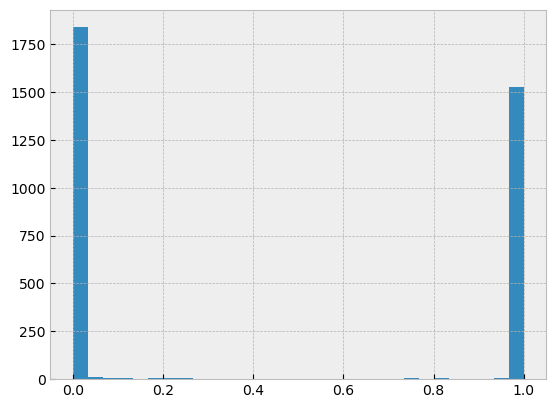

In [21]:
df["prediction"].hist(bins=30)

In [27]:
df.tail()

,return_direction,prediction
date,,
2021-08-25,1,1.000000e+00
2021-08-26,0,1.000000e+00
2021-08-27,1,1.007113e-51
2021-08-30,1,3.326961e-12
2021-08-31,0,5.622762e-135


In [46]:
df.groupby(by=["return_direction"]).count()

,prediction
return_direction,
0,1532
1,1908


### ROC curves and AUC

The roc_curve function from sklearn returns the false positive rates for each threshold, true positive rates for each threshold and thresholds.

In [48]:
buynhold_auc = roc_auc_score(y_true=df["return_direction"], y_score=[1 for _ in range(df.shape[0])])
noskill_auc = roc_auc_score(y_true=df["return_direction"], y_score=[0 for _ in range(df.shape[0])])
model_auc = roc_auc_score(y_true=df["return_direction"], y_score=df["prediction"])

print('Buy n Hold ROC AUC: %.3f' % buynhold_auc)
print('No skill ROC AUC: %.3f' % noskill_auc)
print('Model ROC AUC: %.3f' % model_auc)

Buy n Hold ROC AUC: 0.500
No skill ROC AUC: 0.500
Model ROC AUC: 0.492


Text(0.5, 1.0, 'Logistic vs No skill')

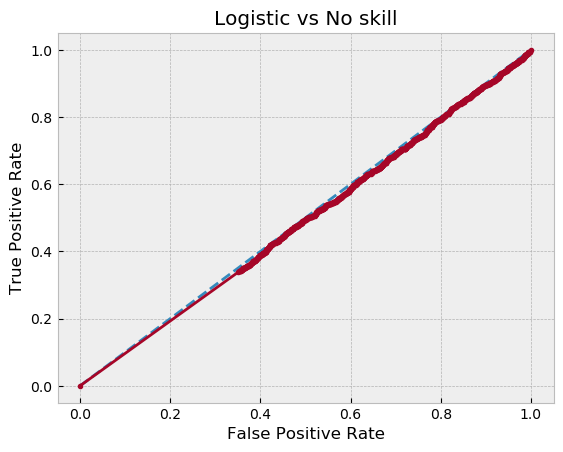

In [54]:
ns_fpr, ns_tpr, _ = roc_curve(df["return_direction"], [0 for _ in range(df.shape[0])])
lr_fpr, lr_tpr, _ = roc_curve(df["return_direction"], df["prediction"])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic vs No skill")

Text(0.5, 1.0, 'Logistic vs Buy n Hold')

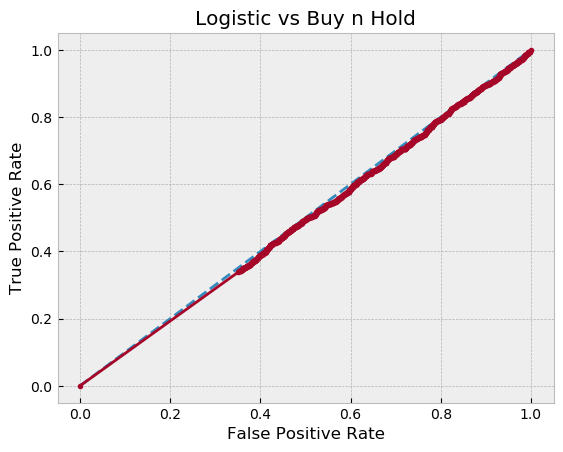

In [53]:
ns_fpr, ns_tpr, _ = roc_curve(df["return_direction"], [1 for _ in range(df.shape[0])])
lr_fpr, lr_tpr, _ = roc_curve(df["return_direction"], df["prediction"])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Buy n hold')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic vs Buy n Hold")

### How to collect google trends data

In [100]:
def quick_get_time_intervals(init_date, final_date):

    intervals = []
    for y in range(int(init_date.split("-")[0]), int(final_date.split("-")[0]), 1):
        intervals.append("{start_date}-01-01 {end_date}-12-31".format(start_date=y, end_date=y+1))

    return intervals

def get_time_intervals(init_date, timedelta="180d"):
    """
    get time intevals starting from the date "init_date"
    until today. Each date interval has "timedelta" days.
    For example, "timedelta=180d" correspond to 6 months.
    Each interval is in the format of the gtrends library.

    :param init_date: initial date
    :type init_date: str
    :param timedelta: time to add
    :type timedelta: str
    :return: list of dates intervals to be used
    :rtype: pd.DataFrame
    """
    intervals = []
    final_date = FINAL_DATE
    var_date = init_date

    while pd.Timestamp(var_date) < pd.Timestamp(final_date):
        next_date = pd.Timestamp(var_date) + pd.Timedelta(timedelta)
        next_date = str(next_date.date())
        timeframe = "{} {}".format(var_date, next_date)
        intervals.append(timeframe)
        var_date = copy(next_date)
    return intervals

In [101]:
from pytrends.request import TrendReq
from tqdm import tqdm

w = "BUY AND HOLD"

# global parameters
SLEEPTIME = 60
INIT_DATE = "2004-01-01"
FINAL_DATE = "2022-08-31"
TIMEZONE_OFFSET = 360
HOST_LANGUAGE = 'en-US'
COUNTRY_ABBREVIATION = 'US'

In [102]:
# timeframes = quick_get_time_intervals(init_date=INIT_DATE, final_date=FINAL_DATE)
timeframes = get_time_intervals(init_date=INIT_DATE)

gtrends = []
for timeframe in tqdm(timeframes, total=len(timeframes)):
    trends = TrendReq(hl=HOST_LANGUAGE, tz=TIMEZONE_OFFSET)
    trends.build_payload(kw_list=[w],
                            geo=COUNTRY_ABBREVIATION,
                            timeframe=timeframe)
    df = trends.interest_over_time()

    gtrends.append(df.drop(["isPartial"], axis=1))

100%|██████████| 38/38 [01:49<00:00,  2.89s/it]


/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


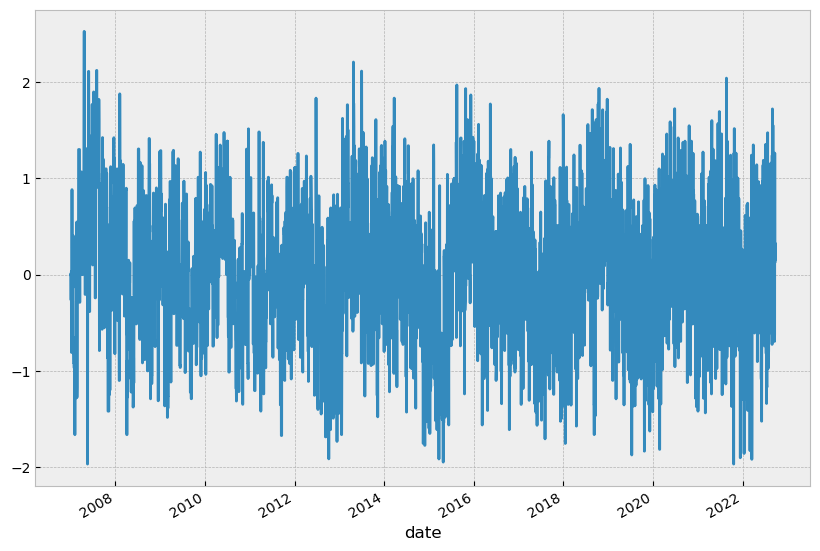

In [122]:
gtrends_df = pd.concat(gtrends, axis=0)
gtrends_df["{} log".format(w)] = np.log(gtrends_df[w]).replace(np.inf, np.nan).replace(-np.inf, np.nan).ffill()
gtrends_df["{} log yoy".format(w)] = gtrends_df["{} log".format(w)].diff(periods=252)

gtrends_df["{} log yoy".format(w)].loc["2007-01-01":].plot(figsize=(10, 7))

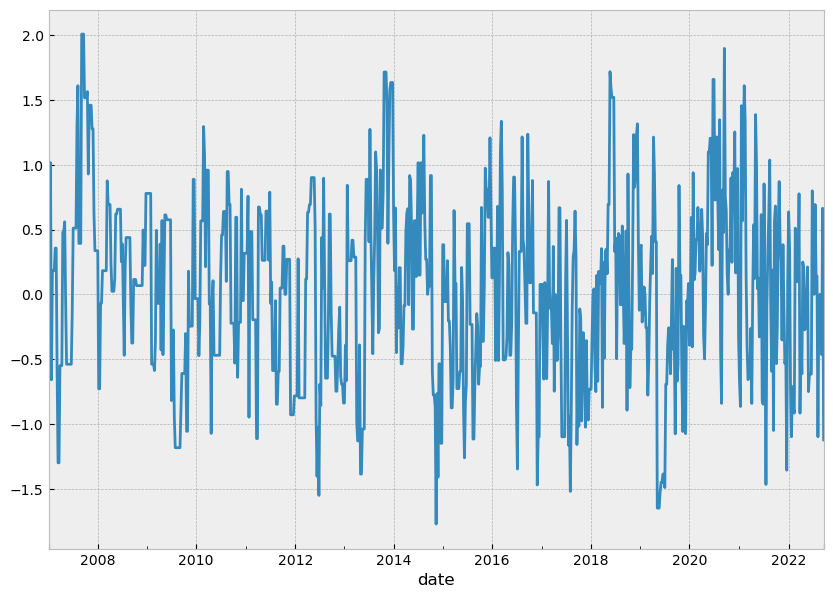

In [124]:
weekly_gtrends_df = pd.concat(gtrends, axis=0).resample("W-FRI").last()
weekly_gtrends_df["{} log".format(w)] = np.log(weekly_gtrends_df[w]).replace(np.inf, np.nan).replace(-np.inf, np.nan).ffill()
weekly_gtrends_df["{} log yoy".format(w)] = weekly_gtrends_df["{} log".format(w)].diff(periods=52)

weekly_gtrends_df["{} log yoy".format(w)].loc["2007-01-01":].plot(figsize=(10, 7))